#### Goal: end-to-end simulation of LSSTxSO cross-correlation.

#### Focus here: uncorrelated galaxy modulation in CMB maps

Steps:
1. Simulate an LSST catalog
    - Choose a halo catalog:
        * Look at the Rockstar halo catalog used in Takahashi sims (link below).
        * Downloaded `skyhalo_nres12r000.halo.gz`. Cleaned it up: keeping ['ID', 'Mvir', 'z_halo', 'theta_i', 'phi_i'] columns for galaxies with pid= -1.
            - Since the catalog is so big (40G), for now, read in chunks so that final sample (with cuts) contains about 10,000 galaxies.
    - Selection to match LSST redmagic
        * Implement cuts on Mvir: 5e12<Mvir<8e13
2. Populate galaxies on HP over-density map
    - Got orphics.catalog to work.
    - PROBLEM: galaxes are at 0,0. Too few?
3. Modulate counts with galactic template
    - Currently have read in estimated numGal data based on lsst depth variation.
    - Added these to the numGal from the haloCat. Modulation dominates rn.
4. Cross-correlate with CMB lensing map: Takahashi sims
    - Downloaded the CMB lensing map data; contains temperature and Q, U polarization. 
    - Read using HEALPix. One map only though?
5. Compare with and without modulation


Takahashi sims: http://cosmo.phys.hirosaki-u.ac.jp/takahasi/allsky_raytracing/nres12.html

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline

import os
import seaborn as sns

from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
os.chdir('..')
home= os.getcwd()
print(home)

/Users/Humna/repos/CMBL-LSS-CrossCorr


In [3]:
filepath= '%s/data/interm//finalOutput_10063gals.csv'%home

In [4]:
data= pd.read_csv(filepath)
print(np.shape(data))
data

(10063, 5)


,ID,Mvir,z_halo,theta_i,phi_i
0,202049.0,7.824000e+12,0.047616,1.548103,3.020566
1,201558.0,9.531000e+12,0.047228,1.552101,2.988574
2,201600.0,1.108000e+13,0.048482,1.532508,2.956538
3,203942.0,5.090000e+12,0.047991,1.569702,2.932756
4,201212.0,1.241000e+13,0.047175,1.530045,2.935767
5,200504.0,1.466000e+13,0.046956,1.499655,2.940550
6,202671.0,8.453000e+12,0.048310,1.449958,2.949284
7,199300.0,2.638000e+13,0.048761,1.448229,2.932930
8,198494.0,3.362000e+13,0.048478,1.431290,2.911829
9,201876.0,5.724000e+12,0.048959,1.296670,3.054511


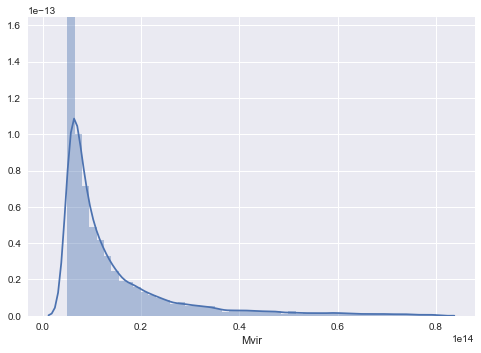

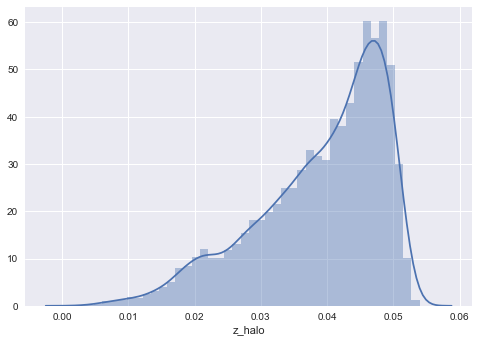

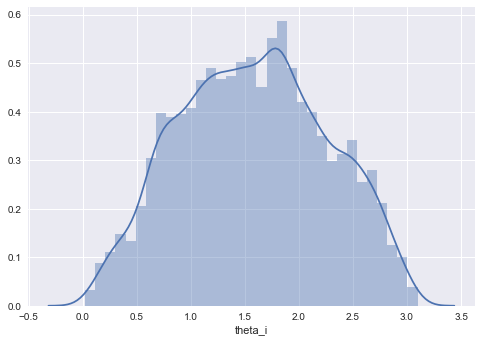

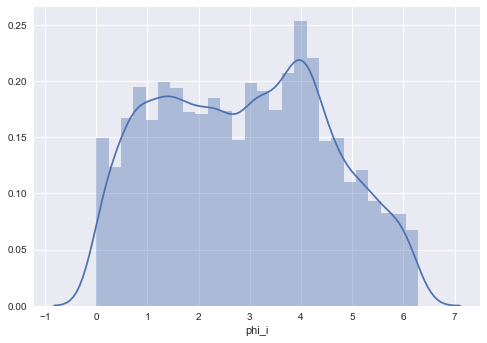

In [5]:
for key in data.keys()[1:]:
    sns.distplot(data[key])
    plt.show()

In [6]:
data['ra'], data['dec']= np.degrees(data['phi_i']), np.degrees(np.pi/2.0-data['theta_i'])

In [7]:
data

,ID,Mvir,z_halo,theta_i,phi_i,ra,dec
0,202049.0,7.824000e+12,0.047616,1.548103,3.020566,173.065695,1.300220
1,201558.0,9.531000e+12,0.047228,1.552101,2.988574,171.232654,1.071169
2,201600.0,1.108000e+13,0.048482,1.532508,2.956538,169.397172,2.193765
3,203942.0,5.090000e+12,0.047991,1.569702,2.932756,168.034553,0.062717
4,201212.0,1.241000e+13,0.047175,1.530045,2.935767,168.207070,2.334902
5,200504.0,1.466000e+13,0.046956,1.499655,2.940550,168.481082,4.076075
6,202671.0,8.453000e+12,0.048310,1.449958,2.949284,168.981503,6.923543
7,199300.0,2.638000e+13,0.048761,1.448229,2.932930,168.044511,7.022591
8,198494.0,3.362000e+13,0.048478,1.431290,2.911829,166.835512,7.993118
9,201876.0,5.724000e+12,0.048959,1.296670,3.054511,175.010595,15.706259


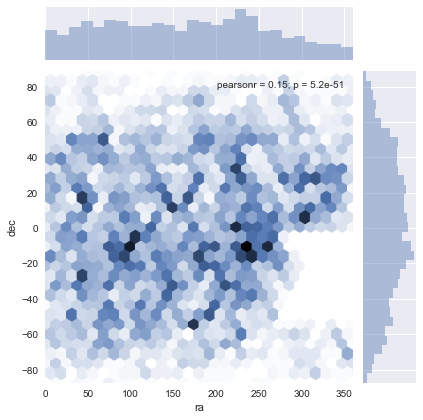

In [8]:
sns.jointplot(x= data['ra'], y= data['dec'], kind= 'hex')

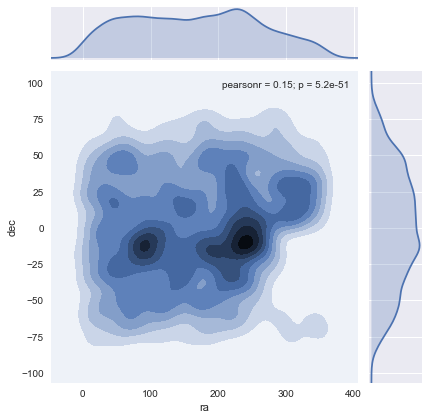

In [9]:
sns.jointplot(x= data['ra'], y= data['dec'], kind= 'kde')

Populate the galaxies on HP map

In [10]:
import sys
cambPath= '/Users/Humna/repos/CAMB/orphics/'
sys.path.insert(0, cambPath)

from orphics.catalogs import CatMapper
from enlib import enmap
from orphics import maps as omaps

In [13]:
catmap= CatMapper(ras_deg= data['ra'], decs_deg= data['dec'], nside= 256)

Calculating pixels...
Done with pixels...
Calculating histogram...


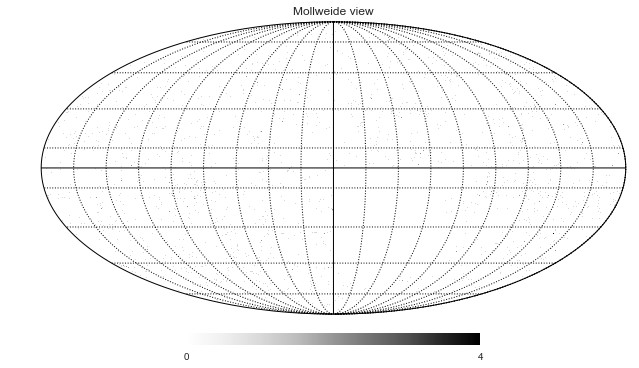

In [14]:
hp.mollview(catmap.counts, flip='astro', rot=(0,0,0))
hp.graticule(dpar=20, dmer=20, verbose=False)

#### Not sure the ra, dec is so limited.

In [15]:
delta = (catmap.counts/catmap.counts.mean())-1.

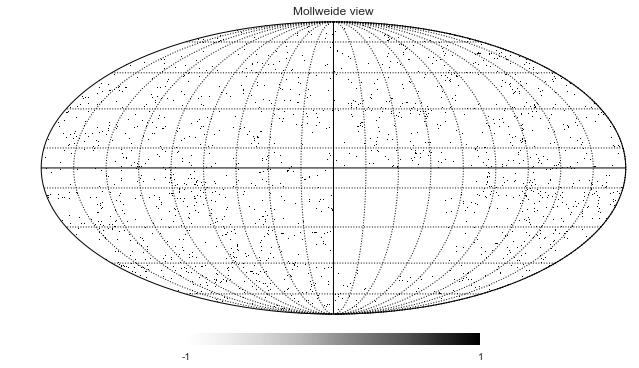

In [16]:
hp.mollview(delta, flip='astro', rot=(0,0,0), min= -1, max= 1)
hp.graticule(dpar=20, dmer=20, verbose=False)

In [17]:
print (catmap.counts.sum())
print (delta.sum())

10063.0
-0.0113831


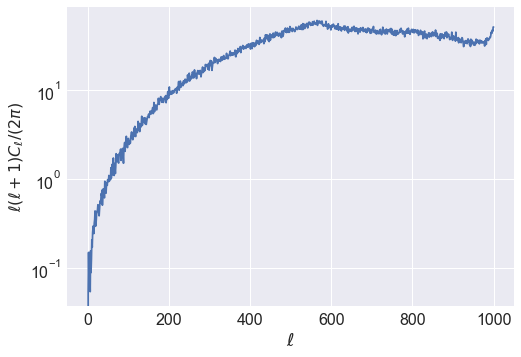

In [18]:
# power spectrum of the overdensity
cl= hp.anafast(map1= delta, lmax= 1000)
ell = np.arange(np.size(cl))
plt.plot(ell, (cl*ell*(ell+1))/2.0/np.pi)
plt.xlabel(r'$\ell$', fontsize=18)
plt.ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)   
plt.gca().set_yscale('log')
plt.show()

ok ..

#### Read in estimated galaxy counts data generated based on variations in depth;
nside= 256; i<27.5; with photometric calibration errors and dust extinction; 0.66<z<1.0

In [19]:
galaxyCountPath= '/Volumes/Transcend/2016-09-09/artificialStructure_noPoissonNoise_nside256_14pixelRadiusForMasking_with0ptErrors_withDustExtinction_i<27.5_minion1016_fullSurveyPeriod_0.66<z<1.0_normalizedGalaxyCounts_directory/numGalData_afterBorderMasking_after0pt/numGalData_masked_with0pt_i_RandomDitherFieldPerVisit.npz'
lsst= np.load(galaxyCountPath)

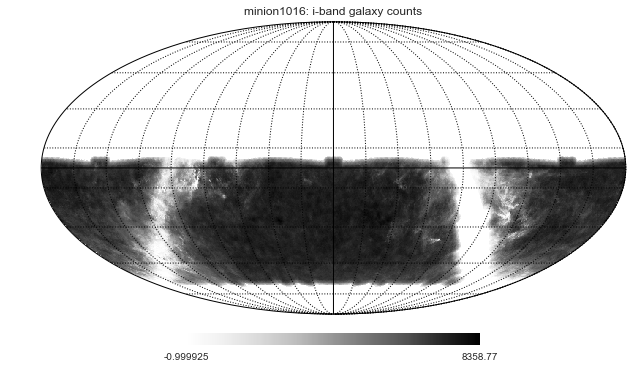

In [20]:
hp.mollview(lsst['metricValues'], flip='astro', rot=(0,0,0), title= 'minion1016: i-band galaxy counts')
hp.graticule(dpar=20, dmer=20, verbose=False)

Combine the two galaxy counts

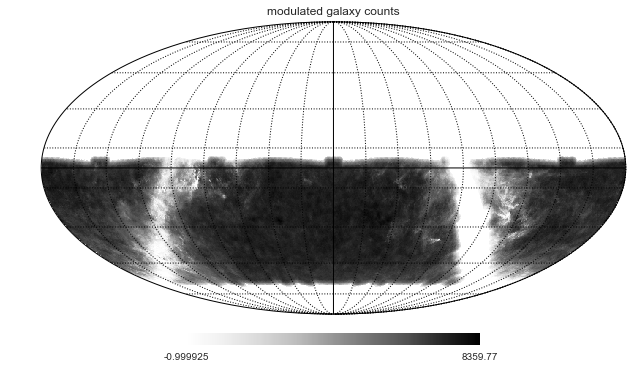

In [21]:
modulatedCounts= lsst['metricValues']+catmap.counts

hp.mollview(modulatedCounts, flip='astro', rot=(0,0,0), title= 'modulated galaxy counts')
hp.graticule(dpar=20, dmer=20, verbose=False)

#### Read in the lensed cmb maps from Takahashi

In [3]:
filename= 'lensed_cmbmap_betazero_nres12r000.fits'
hmap= hp.read_map('%s/data/%s'%(home, filename))

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


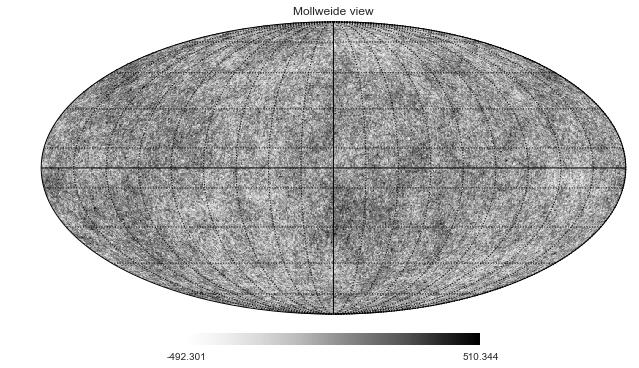

In [4]:
hp.mollview(hmap., flip='astro', rot=(0,0,0))#, title= 'modulated galaxy counts')
hp.graticule(dpar=20, dmer=20, verbose=False)

In [8]:
#from astropy.io import fits

#hdul = fits.open('%s/data/%s'%(home, filename))

#hdul.info()
# hdul[1].header

#cmb_data= hdul[1].data
#totEntries= len(cmb_data)
#print totEntries

#temp= np.zeros(shape= (totEntries, 1024))
#qpol= np.zeros(shape= (totEntries, 1024))

#upol= np.zeros(shape= (totEntries, 1024))

#for i in range(2): #totEntries):
#    hold= cmb_data[i]